# 1) Preparación previa

#### Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ES MUY PROBABLE QUE SE NECESITE INSTALAR PROPHET, A CONTINUACIÓN SE DEJA EL PIP INSTALL:
# !pip install fbprophet
# from fbprophet import Prophet
# from fbprophet.diagnostics import cross_validation
# import itertools
# from fbprophet.diagnostics import performance_metrics

warnings.filterwarnings("ignore")

#### Lectura del dataset

In [2]:
df = pd.read_csv('coin_Bitcoin.csv', delimiter=',')
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


#### Creación de un nuevo DataFrame con las columnas necesarias para trabajar con Prophet:

In [3]:
df2 = pd.DataFrame()

In [4]:
df2['ds'] = df['Date']
df2['y']= df['Close']

In [5]:
# Se cambia el formato de las fechas:
df2['ds'] = pd.to_datetime(df2['ds'])
df2['ds'].dtype

dtype('<M8[ns]')

#### División del dataset en Train y Test, usando rangos personalizados:

In [6]:
end_date = '2021-01-27'
mask1 = (df2['ds'] <= end_date)
mask2 = (df2['ds'] > end_date)

In [7]:
X_tr = df2.loc[mask1]
X_tst = df2.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (2830, 2)
test shape (32, 2)


#### Ploteo de los dos datasets obtenidos:

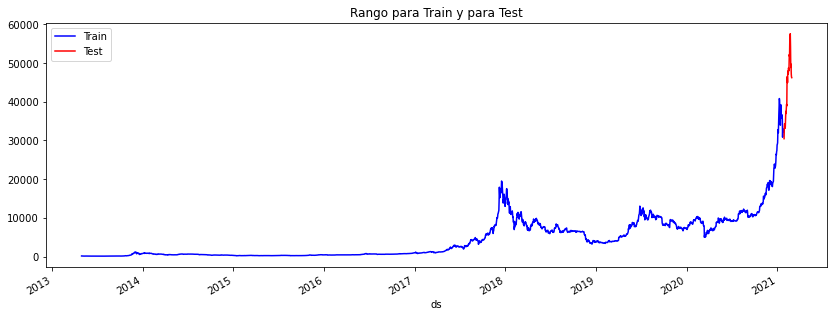

In [8]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Rango para Train y para Test')
plt.show()

#### Se define una función para el cálculo del MAPE:

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 2) Aplicación del modelo Prophet

#### Buscamos la mejor combinación de hiperparámetros:

In [14]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 10.0, 20.0],
    'seasonality_mode' : ('additive', 'multiplicative'),
    'daily_seasonality' : [False, True]
}

# Genera todas las combinaciones de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Usa cross validation para evaluar los parámetros
for params in all_params:
    m = Prophet(**params).fit(X_tr)  # Fit model with given params
    df_cv = cross_validation(m, initial='2500 days' ,period= '15 days',horizon='31 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Encuentra los mejores parámetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59
INFO:fbprophet:Making 20 forecasts with cutoffs between 2020-03-16 23:59:59 and 2020-12-26 23:59:59


    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                      0.01                      1.0         additive   
1                      0.01                      1.0         additive   
2                      0.01                      1.0   multiplicative   
3                      0.01                      1.0   multiplicative   
4                      0.01                     10.0         additive   
5                      0.01                     10.0         additive   
6                      0.01                     10.0   multiplicative   
7                      0.01                     10.0   multiplicative   
8                      0.01                     20.0         additive   
9                      0.01                     20.0         additive   
10                     0.01                     20.0   multiplicative   
11                     0.01                     20.0   multiplicative   
12                     0.10                      1.

#### Análisis de cuál tuvo mejor rendimiento:

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'daily_seasonality': False}


#### Aplicación de los hiperparámetros sobre el modelo y fiteo

In [16]:
final_model = Prophet(changepoint_prior_scale=0.01 ,
                     seasonality_prior_scale = 1.0 ,
                     seasonality_mode= 'multiplicative',
                     daily_seasonality=False)
     
final_model.fit(X_tr)

#### Visualización de un forecast de 31 días con el modelo fiteado en train:

In [17]:
future = final_model.make_future_dataframe(periods=31, freq='D')
forecast = final_model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
2854,2021-02-20 23:59:59,16827.451719,14348.003084,19364.699687
2855,2021-02-21 23:59:59,16922.327681,14249.271898,19381.477580
2856,2021-02-22 23:59:59,17116.676731,14543.131866,19801.327239
2857,2021-02-23 23:59:59,17225.705239,14706.436661,19819.197611
2858,2021-02-24 23:59:59,17277.813194,14682.303173,19908.898829
2859,2021-02-25 23:59:59,17293.690058,14687.584894,19604.150960
2860,2021-02-26 23:59:59,17333.768547,14696.041635,19892.526206


#### Finalmente, en la variable X_tst_final se guarda el predict en test:

In [18]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
25,2021-02-21 23:59:59,16922.327681,14344.501470,19636.901333
26,2021-02-22 23:59:59,17116.676731,14483.875993,19739.305811
27,2021-02-23 23:59:59,17225.705239,14680.606877,19836.913932
28,2021-02-24 23:59:59,17277.813194,14840.264981,19986.013388
29,2021-02-25 23:59:59,17293.690058,14840.065322,19933.216641
30,2021-02-26 23:59:59,17333.768547,14602.831368,19906.131023
31,2021-02-27 23:59:59,17363.716112,14755.369370,20021.927431


#### Ploteo de resultados:

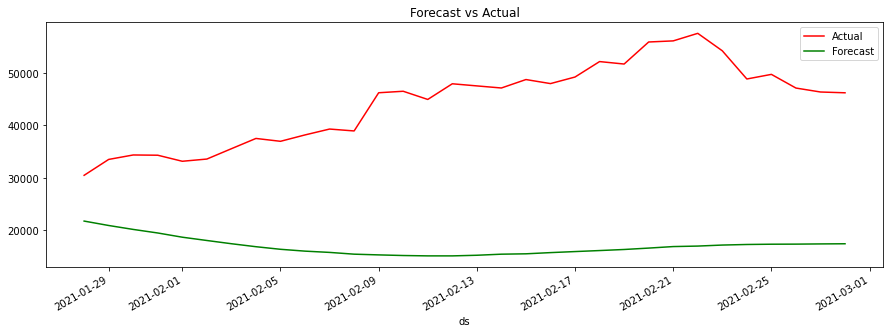

In [19]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actual')
plt.show()

#### Aplicación de la función MAPE

In [20]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 60.178989316360145


Es importante a destacar aquí que no se encuentra el sentido del MAPE, considerando que el RMSE fue de tan solo 6997 (lo cual matemáticamente se corresponde con un MAPE aproximado de 15%, que fue el que se insertó en la notebook 2). De ser 60 de MAPE, el resultado es muy negativo, mientras que de ser 15 se podría considerar al Prophet como un buen modelo